# Introducción

El filtrado colaborativo basado en usuarios, también conocido como filtrado colaborativo usuario-usuario, es un tipo de algoritmo de sistema de recomendación que utiliza la similitud de usuarios para recomendar productos.

En este tutorial, hablaremos sobre:
* ¿Qué es el filtrado colaborativo basado en usuarios (usuario-usuario)?
* ¿Cómo crear una matriz usuario-producto?
* ¿Cómo procesar datos para el filtrado colaborativo basado en usuarios?
* ¿Cómo identificar usuarios similares?
* ¿Cómo delimitar el conjunto de elementos?
* ¿Cómo clasificar los elementos para la recomendación?
* ¿Cómo predecir la puntuación?

**Hecho por prof. Carlos Ogando.**

*Este cuaderno está basado en los recursos de* [GrabnGoInfo](https://www.youtube.com/watch?v=cxcFi3RDrEw&list=PLVppujud2yJqshyM80nNDZgye-AFufyqF&index=1)


# Paso 0: Algoritmo de recomendación de filtrado colaborativo basado en el usuario

En primer lugar, comprendamos cómo funciona el filtrado colaborativo basado en usuarios.

El filtrado colaborativo basado en usuarios genera recomendaciones basadas en interacciones previas entre usuarios y productos. El algoritmo presupone que a usuarios similares les gustan productos similares.

El algoritmo de filtrado colaborativo basado en usuarios suele constar de los siguientes pasos:

1. Encontrar usuarios similares basándose en interacciones con elementos comunes.
2. Identificar los elementos con alta calificación por usuarios similares, pero que no han sido expuestos al usuario activo de interés.
3. Calcular la puntuación media ponderada de cada elemento.
4. Clasificar los elementos según su puntuación y seleccionar los n elementos principales para recomendar.

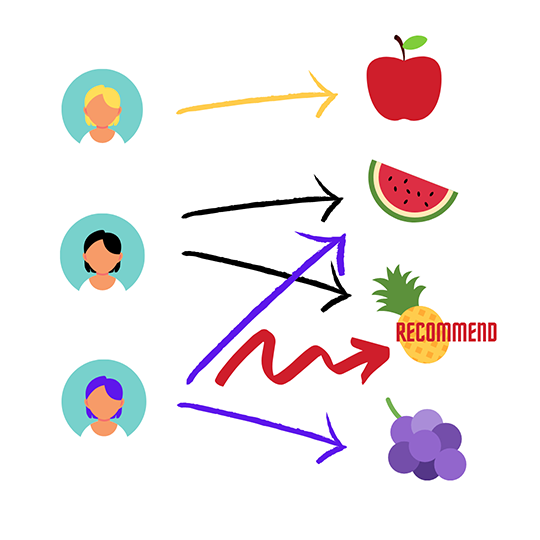

Este gráfico ilustra cómo funciona el filtrado colaborativo basado en el usuario con un ejemplo simplificado.
* A la Sra. Rubia le gustan las manzanas. A la Sra. Negra le gustan la sandía y la piña. A la Sra. Morada le gustan la sandía y las uvas.
* Dado que a la Sra. Negra y a la Sra. Morada les gusta la misma fruta, la sandía, son usuarias similares.
* Dado que a la Sra. Negra le gusta la piña y la Sra. Morada aún no ha estado expuesta a ella, el sistema de recomendaciones le recomienda la piña a la Sra. Morada.

# Paso 1: Importar librerías de Python

En el primer paso, importaremos las librerías de Python «pandas», «numpy» y «scipy.stats». Estas tres librerías se utilizan para el procesamiento y cálculo de datos.

También importamos «seaborn» para la visualización y «cosine_similarity» para calcular la puntuación de similitud.

In [1]:
# Procesamiento de datos
import pandas as pd
import numpy as np
import scipy.stats

# Visualización
import seaborn as sns

# Similaridad
from sklearn.metrics.pairwise import cosine_similarity

# Paso 2: Descargar y leer los datos

Este tutorial utiliza el conjunto de datos movielens. Este conjunto de datos contiene valoraciones reales de películas por parte de los usuarios.

En el paso 2, emplearemos el API de Google Drive para suplirnos de los conjuntos de datos.

*   La fuente que usaremos de kaggle será https://www.kaggle.com/datasets/ayushimishra2809/movielens-dataset?select=ratings.csv
*   La fuente original de los datos es http://movielens.org.

Pueden también usar sus propios datasets si así desean subiéndolos directamente al almacén de archivos temporales de Colab ubicado en el menú de la izquierda.

Hay varios conjuntos de datos en la carpeta 100k movielens. Para este tutorial, usaremos dos: ratings y películas.
Ahora, leamos los datos de ratings.

In [5]:
# Leer datos
ratings = pd.read_csv('Dataset películas/ratings.csv')

# Revisar la data
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


El conjunto de datos de calificaciones consta de cuatro columnas: ID de usuario, ID de película, calificación y marca de tiempo.

El conjunto de datos contiene más de 100 000 registros y no hay datos faltantes.

In [6]:
# Obtener la información del dataset
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB


Las 100.000 calificaciones provienen de 668 usuarios en 10,325 películas. La calificación tiene diez valores únicos, de 0,5 a 5.

In [8]:
# Número de usuarios
print('El dataset de ratings tiene', ratings['userId'].nunique(), 'usuarios únicos')

# Número de películas
print('El dataset de ratings tiene', ratings['movieId'].nunique(), 'películas únicas')

# Número de ratings
print('El dataset de ratings tiene', ratings['rating'].nunique(), 'ratings únicos')

# Listado de ratings únicos
print('Los ratings únicos son', sorted(ratings['rating'].unique()))

El dataset de ratings tiene 668 usuarios únicos
El dataset de ratings tiene 10325 películas únicas
El dataset de ratings tiene 10 ratings únicos
Los ratings únicos son [np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]


A continuación, leamos los datos de películas para obtener sus nombres.

El conjunto de datos de películas incluye el ID de la película, el título y los géneros.

In [10]:
# Leer datos
movies = pd.read_csv('Dataset películas/movies.csv')

# Revisión rápida
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


Usando "movieID" como clave de coincidencia, agregamos la información de la película al conjunto de datos de clasificación y lo llamamos "df". Ahora tenemos el título y la clasificación de la película en el mismo conjunto de datos

In [13]:
# Unir datasets
df = pd.merge(ratings, movies, on='movieId', how='inner')

# Revisar resultado
df.head()

,userId,movieId,rating,timestamp,title,genres
0,1,16,4.0,1217897793,Casino (1995),Crime|Drama
1,1,24,1.5,1217895807,Powder (1995),Drama|Sci-Fi
2,1,32,4.0,1217896246,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller
3,1,47,4.0,1217896556,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,4.0,1217896523,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


# Paso 3: Análisis exploratorio de datos (EDA)

En el paso 3, necesitamos filtrar las películas y conservar solo aquellas con más de 100 valoraciones para el análisis. Esto facilita el cálculo en la memoria de Google Colab.

Para ello, primero agrupamos las películas por título, contamos el número de valoraciones y conservamos solo las películas con más de 100 valoraciones.

También se calculan las valoraciones promedio de las películas.

En la salida de `.info()`, podemos ver que quedan 134 películas.

In [17]:
# Agregar películas
agg_ratings = df.groupby('title').agg(
    mean_rating = ('rating', 'mean'),
    number_of_ratings = ('rating', 'count')
).reset_index()

# Filtrar solo el top 100 de ratings
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings']>100]
agg_ratings_GT100.info()

<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 60 to 10204
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              150 non-null    object 
 1   mean_rating        150 non-null    float64
 2   number_of_ratings  150 non-null    int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 4.7+ KB


Veamos cuáles son las películas más populares y sus valoraciones.

In [ ]:
# Revisar películas famosas
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

,title,mean_rating,number_of_ratings
7323,Pulp Fiction (1994),4.160000,325
3349,Forrest Gump (1994),4.138264,311
8136,"Shawshank Redemption, The (1994)",4.454545,308
4934,Jurassic Park (1993),3.659864,294
8228,"Silence of the Lambs, The (1991)",4.194828,290


A continuación, utilicemos un diagrama conjunto para comprobar la correlación entre la calificación promedio y el número de calificaciones.

Observamos una tendencia ascendente en el diagrama de dispersión, que muestra que las películas populares obtienen calificaciones más altas.

La distribución de la calificación promedio muestra que la mayoría de las películas del conjunto de datos tienen una calificación promedio de alrededor de 4.

La distribución del número de calificaciones muestra que la mayoría de las películas tienen menos de 150 calificaciones.

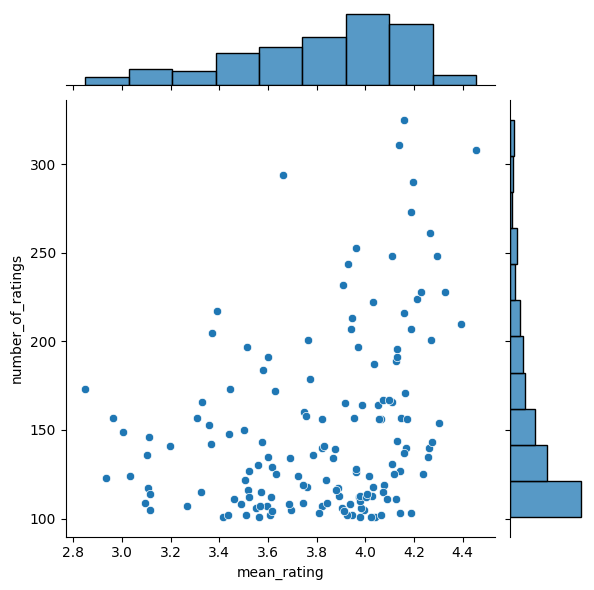

In [ ]:
# Visualización
sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

Para conservar solo las 150 películas con más de 100 calificaciones, necesitamos unir la película con el marco de datos de nivel de calificación del usuario.

`how='inner'` y `on='title'` garantizan que solo se incluyan las películas con más de 100 calificaciones.

In [19]:
# Unir datos
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22556 entries, 0 to 22555
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   userId     22556 non-null  int64  
 1   movieId    22556 non-null  int64  
 2   rating     22556 non-null  float64
 3   timestamp  22556 non-null  int64  
 4   title      22556 non-null  object 
 5   genres     22556 non-null  object 
dtypes: float64(1), int64(3), object(2)
memory usage: 1.0+ MB


Después de filtrar las películas con más de 100 calificaciones, tenemos 653 usuarios que calificaron 150 películas.

In [20]:
# Número de usuarios
print('El dataset de ratings tiene', df_GT100['userId'].nunique(), 'usuarios únicos')

# Número de películas
print('El dataset de ratings tiene', df_GT100['movieId'].nunique(), 'películas únicas')

# Número de ratings
print('El dataset de ratings tiene', df_GT100['rating'].nunique(), 'ratings únicos')

# Listado de ratings únicos
print('Los ratings únicos son', sorted(df_GT100['rating'].unique()))

El dataset de ratings tiene 653 usuarios únicos
El dataset de ratings tiene 150 películas únicas
El dataset de ratings tiene 10 ratings únicos
Los ratings únicos son [np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]


# Paso 4: Crear una matriz de Película-Usuario

En el paso 4, transformaremos el conjunto de datos a una matriz. Las filas de la matriz representan los usuarios y las columnas las películas. El valor de la matriz es la calificación de la película por parte de los usuarios, si la hay. De lo contrario, se mostrará "NaN".

In [22]:
# Crear matriz usuario-item
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')
matrix.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),"Usual Suspects, The (1995)",Waterworld (1995),While You Were Sleeping (1995),Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)",X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,4.0,3.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,3.0,4.0,NaN,NaN,NaN,NaN,4.0,NaN,NaN
3,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,3.0,5.0,NaN,3.0,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,5.0,NaN
5,NaN,1.0,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Paso 5: Normalización de datos

Dado que algunas personas tienden a dar una calificación más alta que otras, normalizamos la calificación extrayendo la calificación promedio de cada usuario.

Tras la normalización, las películas con una calificación menor a la calificación promedio del usuario obtienen un valor negativo, y las películas con una calificación mayor a la calificación promedio del usuario, un valor positivo.

In [23]:
# Normalización de la matriz usuario-item
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis = 'rows')
matrix_norm.head()

title,2001: A Space Odyssey (1968),Ace Ventura: Pet Detective (1994),Aladdin (1992),Alien (1979),Aliens (1986),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",American Beauty (1999),American History X (1998),American Pie (1999),Apocalypse Now (1979),...,"Truman Show, The (1998)",Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),"Usual Suspects, The (1995)",Waterworld (1995),While You Were Sleeping (1995),Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971),"Wizard of Oz, The (1939)",X-Men (2000)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,0.169231,NaN,NaN,NaN,...,NaN,0.169231,-0.830769,0.169231,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,-1.111111,-0.111111,NaN,NaN,NaN,NaN,-0.111111,NaN,NaN
3,NaN,NaN,-0.714286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.714286,1.285714,NaN,-0.714286,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.937500,NaN,NaN,NaN,NaN,0.9375,NaN,0.9375,NaN
5,NaN,-1.7,0.800000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Paso 6: Identificar usuarios similares

Existen diferentes maneras de medir similitudes. La correlación de Pearson y la similitud de coseno son dos métodos ampliamente utilizados.

En este tutorial, calcularemos la matriz de similitud de usuarios mediante la correlación de Pearson.

In [29]:
# Matriz de similitud de usuarios utilizando correlación de Pearson
user_similarity = matrix_norm.T.corr()
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.306186,0.614559,0.431124,-0.094491,0.471405,0.153463,0.369274,0.195776,-1.0,...,0.099066,0.375769,0.107583,0.349334,0.410803,-0.505322,0.029258,0.018696,0.144082,0.230468
2,-0.306186,1.000000,0.866025,-1.000000,NaN,NaN,-0.555556,0.577350,0.333333,NaN,...,-1.000000,NaN,0.816497,-0.577350,NaN,NaN,-0.174078,NaN,-1.000000,0.388556
3,0.614559,0.866025,1.000000,NaN,0.162938,NaN,-0.228587,1.000000,0.391121,-1.0,...,0.345186,0.585540,1.000000,0.000000,0.252050,-0.491398,0.484123,0.336336,0.392989,0.231076
4,0.431124,-1.000000,NaN,1.000000,NaN,NaN,-0.115186,NaN,-0.250000,NaN,...,-0.662266,NaN,-1.000000,0.408248,NaN,NaN,-0.801784,-0.063610,0.965824,0.291551
5,-0.094491,NaN,0.162938,NaN,1.000000,-0.970725,0.077671,NaN,-0.158114,NaN,...,-0.427828,NaN,NaN,0.960769,NaN,-0.548611,0.104257,-0.944911,-0.052658,-0.113529


Quienes estén interesados ​​en usar la similitud de coseno pueden consultar este código. Dado que `cosine_similarity` no acepta valores faltantes, debemos imputarlos con ceros antes del cálculo.

In [25]:
# Matriz de similitud de usuarios utilizando similaridad del coseno
user_similarity_cosine = pd.DataFrame(cosine_similarity(matrix_norm.fillna(0)),
                                      columns=user_similarity.columns, index=user_similarity.index)
user_similarity_cosine.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,-0.035830,0.206015,0.079337,-0.011293,0.058817,0.074279,0.049303,0.049409,-0.010772,...,0.055534,0.096663,0.026969,0.144731,0.126032,-0.148462,0.016409,0.021231,0.042608,0.125065
2,-0.035830,1.000000,0.152326,-0.148343,0.107229,-0.017177,-0.083182,0.372104,-0.012354,0.000000,...,0.033733,0.000000,0.415301,-0.158274,-0.139983,0.009350,0.024708,0.073110,-0.078141,0.077384
3,0.206015,0.152326,1.000000,-0.012940,0.028421,-0.021129,-0.059749,0.117897,0.252470,-0.114153,...,0.092838,0.152893,0.217485,-0.049378,0.100799,-0.108868,0.123886,0.082288,0.106890,0.103993
4,0.079337,-0.148343,-0.012940,1.000000,-0.144293,-0.029302,-0.042817,-0.068126,-0.005428,0.000000,...,-0.007525,-0.002226,0.028577,0.035839,-0.010484,0.004669,-0.014385,-0.031258,0.307073,0.106771
5,-0.011293,0.107229,0.028421,-0.144293,1.000000,-0.108723,0.025429,0.064838,-0.014903,-0.038633,...,-0.080723,-0.107563,-0.078646,0.081995,-0.019957,-0.079261,0.177944,-0.061092,-0.002459,-0.043177


Ahora, usemos el ID de usuario 1 como ejemplo para ilustrar cómo encontrar usuarios similares.

Primero, debemos excluir el ID de usuario 1 de la lista de usuarios similares y determinar el número de usuarios similares.

In [30]:
# Tomamos un ID de usuario
picked_userid = 1

# Eliminamos el ID del usuario seleccionado de la lista de candidatos
user_similarity.drop(index=picked_userid, inplace=True)

# Revisemos
user_similarity.head()

userId,1,2,3,4,5,6,7,8,9,10,...,659,660,661,662,663,664,665,666,667,668
userId,,,,,,,,,,,,,,,,,,,,,
2,-0.306186,1.000000,0.866025,-1.0,NaN,NaN,-0.555556,0.57735,0.333333,NaN,...,-1.000000,NaN,0.816497,-0.577350,NaN,NaN,-0.174078,NaN,-1.000000,0.388556
3,0.614559,0.866025,1.000000,NaN,0.162938,NaN,-0.228587,1.00000,0.391121,-1.0,...,0.345186,0.58554,1.000000,0.000000,0.25205,-0.491398,0.484123,0.336336,0.392989,0.231076
4,0.431124,-1.000000,NaN,1.0,NaN,NaN,-0.115186,NaN,-0.250000,NaN,...,-0.662266,NaN,-1.000000,0.408248,NaN,NaN,-0.801784,-0.063610,0.965824,0.291551
5,-0.094491,NaN,0.162938,NaN,1.000000,-0.970725,0.077671,NaN,-0.158114,NaN,...,-0.427828,NaN,NaN,0.960769,NaN,-0.548611,0.104257,-0.944911,-0.052658,-0.113529
6,0.471405,NaN,NaN,NaN,-0.970725,1.000000,0.309426,NaN,NaN,NaN,...,0.302614,NaN,NaN,0.132453,NaN,NaN,-0.166667,NaN,1.000000,-0.080930


En la matriz de similitud de usuarios, los valores van de -1 a 1, donde -1 significa preferencias de películas opuestas y 1 significa la misma preferencia.

«n = 10» significa que queremos seleccionar a los 10 usuarios más similares para el ID de usuario 1.

El filtrado colaborativo basado en usuarios realiza recomendaciones basadas en usuarios con gustos similares, por lo que debemos establecer un umbral positivo. Aquí, establecemos «user_similarity_threshold» en 0,3, lo que significa que un usuario debe tener un coeficiente de correlación de Pearson de al menos 0,3 para ser considerado similar.

Después de establecer el número de usuarios similares y el umbral de similitud, ordenamos el valor de similitud de los usuarios del mayor al menor, y luego imprimimos el ID de los usuarios más similares y el valor de correlación de Pearson.

In [36]:
# Número de usuarios similares
n = 10

# Threshold de similaridad
user_similarity_threshold = 0.3

# Obtener top n usuarios similares
similar_users = user_similarity[user_similarity[picked_userid]>user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Impresión de resultados
print(f'The similar users for user {picked_userid} are', similar_users)

The similar users for user 1 are userId
154    1.000000
117    1.000000
67     1.000000
34     1.000000
533    1.000000
621    0.981981
526    0.966988
103    0.945343
271    0.943300
26     0.940582
Name: 1, dtype: float64


# Paso 7: Reducir el grupo de artículos

En el paso 7, reduciremos el conjunto de elementos mediante los siguientes pasos:
1. Eliminar las películas que ha visto el usuario objetivo (ID de usuario 1 en este ejemplo).
2. Conservar solo las películas que han visto usuarios similares.

Para eliminar las películas que ha visto el usuario objetivo, conservamos solo la fila `userId=1` en la matriz usuario-elemento y eliminamos los elementos con valores faltantes.

In [37]:
# Películas que el usuario objetivo ha visto
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

title,American Beauty (1999),Apollo 13 (1995),Back to the Future (1985),Batman (1989),Batman Begins (2005),"Beautiful Mind, A (2001)","Bourne Identity, The (2002)",Braveheart (1995),Casablanca (1942),Clear and Present Danger (1994),...,Star Wars: Episode IV - A New Hope (1977),Star Wars: Episode V - The Empire Strikes Back (1980),Star Wars: Episode VI - Return of the Jedi (1983),Terminator 2: Judgment Day (1991),There's Something About Mary (1998),Titanic (1997),True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),"Usual Suspects, The (1995)"
userId,,,,,,,,,,,,,,,,,,,,,
1,0.169231,-0.830769,-0.830769,-1.330769,0.669231,0.169231,0.169231,0.169231,1.169231,0.669231,...,0.669231,0.669231,0.669231,-0.330769,-2.330769,-2.330769,-0.830769,0.169231,-0.830769,0.169231


Para conservar solo las películas de usuarios similares, mantenemos los ID de usuario en las listas de los 10 usuarios más similares y eliminamos la película con todos los valores faltantes. Si faltan todos los valores de una película, significa que ninguno de los usuarios similares la ha visto.

In [38]:
# Películas que vieron usuarios similares. Eliminar películas que ninguno de los usuarios similares haya visto.
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

title,American Beauty (1999),American Pie (1999),Austin Powers: The Spy Who Shagged Me (1999),Batman Begins (2005),Being John Malkovich (1999),"Breakfast Club, The (1985)",Broken Arrow (1996),"Bug's Life, A (1998)",Casablanca (1942),Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),...,Star Wars: Episode VI - Return of the Jedi (1983),There's Something About Mary (1998),Titanic (1997),Total Recall (1990),Toy Story (1995),Trainspotting (1996),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Twister (1996),Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971)
userId,,,,,,,,,,,,,,,,,,,,,
26,NaN,NaN,-0.416667,NaN,1.083333,NaN,NaN,NaN,0.583333,NaN,...,NaN,-1.916667,NaN,NaN,NaN,NaN,NaN,NaN,0.583333,NaN
34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.400,...,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,-0.125,NaN,-0.625000,NaN,-0.125000,-0.625,NaN,NaN,NaN,0.875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.875,-0.875,0.125,NaN,NaN,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.000,NaN,NaN,-1.0,NaN,-1.0
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-1.000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,-1.000,-1.0,0.0,-1.0,NaN,1.0
526,NaN,0.4,0.400000,NaN,NaN,NaN,-0.6,-0.6,NaN,NaN,...,0.4,NaN,-1.600,NaN,NaN,NaN,NaN,NaN,NaN,NaN
533,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


A continuación, eliminaremos las películas que vio el usuario ID 1 de la lista de películas de usuarios similares. `errors='ignore'` elimina las columnas si existen sin mostrar un mensaje de error.

In [41]:
# Eliminemos las películas ya vistas de la lista a recomendar
similar_user_movies.drop(picked_userid_watched.columns,axis=1, inplace=True, errors='ignore')

# Revisemos
similar_user_movies

title,American Pie (1999),Austin Powers: The Spy Who Shagged Me (1999),Being John Malkovich (1999),"Breakfast Club, The (1985)",Broken Arrow (1996),"Bug's Life, A (1998)",Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb (1964),E.T. the Extra-Terrestrial (1982),Ferris Bueller's Day Off (1986),"Fifth Element, The (1997)",...,"Hunt for Red October, The (1990)",In the Line of Fire (1993),Kill Bill: Vol. 1 (2003),Memento (2000),"Rock, The (1996)",Total Recall (1990),Toy Story (1995),Trainspotting (1996),Who Framed Roger Rabbit? (1988),Willy Wonka & the Chocolate Factory (1971)
userId,,,,,,,,,,,,,,,,,,,,,
26,NaN,-0.416667,1.083333,NaN,NaN,NaN,NaN,NaN,NaN,-1.416667,...,0.083333,-0.416667,NaN,NaN,NaN,NaN,NaN,NaN,0.583333,NaN
34,NaN,NaN,NaN,NaN,NaN,NaN,0.400,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,NaN,-0.625000,-0.125000,-0.625,NaN,NaN,0.875,NaN,NaN,0.875000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
103,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.125,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,-0.875,0.125,NaN,NaN,NaN
117,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,0.000,NaN,NaN,-1.0
154,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
271,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,NaN,-1.000,-1.0,NaN,1.0
526,0.4,0.400000,NaN,NaN,-0.6,-0.6,NaN,NaN,0.4,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
533,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Paso 8: Recomendar artículos

En el paso 8, decidiremos qué película recomendar al usuario objetivo. Los artículos recomendados se determinan mediante el promedio ponderado de la puntuación de similitud del usuario y la calificación de la película. Las calificaciones de las películas se ponderan según las puntuaciones de similitud, por lo que los usuarios con mayor similitud obtienen mayor ponderación.

Este código recorre los artículos y usuarios para obtener la puntuación del artículo, ordenarla de mayor a menor y seleccionar las 10 mejores películas para recomendar al usuario ID 1.

In [50]:
# Un diccionario para almacenar puntuaciones de artículos
item_score = {}

# Iterar por cada película
for i in similar_user_movies.columns:
  # Obtener las calificaciones de la película i
  movie_rating = similar_user_movies[i]
  # Crea una variable para almacenar la puntuación
  total = 0
  # Crea una variable para almacenar el número de puntuaciones
  count = 0
  # Recorrer usuarios similares
  for u in similar_users.index:
    # Si la película tiene clasificación
    if pd.isna(movie_rating[u]) == False:
      # La puntuación es la suma de la puntuación de similitud del usuario multiplicada por la calificación de la película
      score = similar_users[u] * movie_rating[u]
      # Añade la puntuación a la puntuación total de la película hasta el momento
      total += score
      # Añade 1 al total
      count +=1
  # Obtener la puntuación media del artículo
  item_score[i] = total / count

# Convertir diccionario a marco de datos de pandas
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])

# Ordenar las películas por puntuación
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Seleccionar las mejores películas m
m = 10
ranked_item_score.head(m)

,movie,movie_score
12,Heat (1995),0.971650
6,Dr. Strangelove or: How I Learned to Stop Worr...,0.637500
21,Who Framed Roger Rabbit? (1988),0.548673
15,Kill Bill: Vol. 1 (2003),0.490990
2,Being John Malkovich (1999),0.446982
0,American Pie (1999),0.386795
8,Ferris Bueller's Day Off (1986),0.193398
7,E.T. the Extra-Terrestrial (1982),0.118168
13,"Hunt for Red October, The (1990)",0.078382
17,"Rock, The (1996)",0.000000


# Paso 9: Predecir puntuaciones (opcional)

Si el objetivo es elegir los artículos recomendados, basta con conocer su clasificación. Sin embargo, si el objetivo es predecir la calificación del usuario, debemos sumar la calificación promedio de la película a la puntuación de la película.

In [52]:
# Calificación promedio del usuario seleccionado
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Imprimir la calificación promedio de la película para el usuario 1
print(f'La calificación promedio de la película por el usuario {picked_userid} es {avg_rating:.2f}')

La calificación promedio de la película por el usuario 1 es 3.83


La calificación promedio de la película para el usuario 1 es 3.83, por lo que agregamos 3.83 a la puntuación de la película.

In [53]:
# Calcular el rating predicho
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

# Revisemos
ranked_item_score.head(m)

,movie,movie_score,predicted_rating
12,Heat (1995),0.971650,4.802419
6,Dr. Strangelove or: How I Learned to Stop Worr...,0.637500,4.468269
21,Who Framed Roger Rabbit? (1988),0.548673,4.379442
15,Kill Bill: Vol. 1 (2003),0.490990,4.321759
2,Being John Malkovich (1999),0.446982,4.277751
0,American Pie (1999),0.386795,4.217564
8,Ferris Bueller's Day Off (1986),0.193398,4.024167
7,E.T. the Extra-Terrestrial (1982),0.118168,3.948937
13,"Hunt for Red October, The (1990)",0.078382,3.909151
17,"Rock, The (1996)",0.000000,3.830769


Podemos ver que las 10 películas más recomendadas tienen calificaciones altas.

# Paso 10: Unir todo el código

In [55]:
###### Paso 1: Importar librerías de Python

# Procesamiento de datos
import pandas as pd
import numpy as np
import scipy.stats

# Visualización
import seaborn as sns

# Similitud
from sklearn.metrics.pairwise import cosine_similarity


###### Paso 2: Descargar y leer los datos

# Leer datos
ratings = pd.read_csv('Dataset películas/ratings.csv')

# Revisar la data
ratings.head()

# Obtener información del dataset
ratings.info()

# Número de usuarios
print('El conjunto de datos de calificaciones tiene', ratings['userId'].nunique(), 'usuarios únicos')

# Número de películas
print('El conjunto de datos de calificaciones tiene', ratings['movieId'].nunique(), 'películas únicas')

# Número de calificaciones
print('El conjunto de datos de calificaciones tiene', ratings['rating'].nunique(), 'calificaciones únicas')

# Lista de calificaciones únicas
print('Las calificaciones únicas son', sorted(ratings['rating'].unique()))

# Leer los datos
movies = pd.read_csv('Dataset películas/movies.csv')

# Ver una muestra de los datos
movies.head()

# Unir los datasets de calificaciones y películas
df = pd.merge(ratings, movies, on='movieId', how='inner')

# Ver una muestra de los datos
df.head()


###### Paso 3: Análisis exploratorio de datos (EDA)

# Agrupar por película
agg_ratings = df.groupby('title').agg(mean_rating = ('rating', 'mean'),
                                       number_of_ratings = ('rating', 'count')).reset_index()

# Conservar solo las películas con más de 100 calificaciones
agg_ratings_GT100 = agg_ratings[agg_ratings['number_of_ratings'] > 100]
agg_ratings_GT100.info()

# Revisar las películas más populares
agg_ratings_GT100.sort_values(by='number_of_ratings', ascending=False).head()

# Visualización
#sns.jointplot(x='mean_rating', y='number_of_ratings', data=agg_ratings_GT100)

# Unir datos
df_GT100 = pd.merge(df, agg_ratings_GT100[['title']], on='title', how='inner')
df_GT100.info()

# Número de usuarios
print('El conjunto de datos tiene', df_GT100['userId'].nunique(), 'usuarios únicos')

# Número de películas
print('El conjunto de datos tiene', df_GT100['movieId'].nunique(), 'películas únicas')

# Número de calificaciones
print('El conjunto de datos tiene', df_GT100['rating'].nunique(), 'calificaciones únicas')

# Lista de calificaciones únicas
print('Las calificaciones únicas son', sorted(df_GT100['rating'].unique()))


###### Paso 4: Crear matriz usuario-película

# Crear la matriz usuario-item
matrix = df_GT100.pivot_table(index='userId', columns='title', values='rating')
matrix.head()


###### Paso 5: Normalización de datos

# Normalizar la matriz usuario-item
matrix_norm = matrix.subtract(matrix.mean(axis=1), axis='rows')
matrix_norm.head()


###### Paso 6: Identificar usuarios similares

# Matriz de similitud entre usuarios usando correlación de Pearson
user_similarity = matrix_norm.T.corr()
user_similarity.head()

# Eliminamos el ID del usuario seleccionado de la lista de candidatos
user_similarity.drop(index=picked_userid, inplace=True)

# Matriz de similitud entre usuarios usando similitud de coseno
user_similarity_cosine = cosine_similarity(matrix_norm.fillna(0))
user_similarity_cosine

# Número de usuarios similares
n = 10

# Umbral de similitud
user_similarity_threshold = 0.3

# Obtener los top n usuarios similares
similar_users = user_similarity[user_similarity[picked_userid] > user_similarity_threshold][picked_userid].sort_values(ascending=False)[:n]

# Imprimir los top n usuarios similares
print(f'Los usuarios similares al usuario {picked_userid} son', similar_users)


###### Paso 7: Reducir el conjunto de películas

# Eliminar las películas que ya han sido vistas
picked_userid_watched = matrix_norm[matrix_norm.index == picked_userid].dropna(axis=1, how='all')
picked_userid_watched

# Películas vistas por usuarios similares. Eliminar películas que ninguno de los usuarios similares ha visto
similar_user_movies = matrix_norm[matrix_norm.index.isin(similar_users.index)].dropna(axis=1, how='all')
similar_user_movies

# Eliminar las películas ya vistas del conjunto de películas
similar_user_movies.drop(picked_userid_watched.columns, axis=1, inplace=True, errors='ignore')

# Ver los datos
similar_user_movies


###### Paso 8: Recomendar ítems

# Diccionario para almacenar los puntajes de cada película
item_score = {}

# Recorrer las películas
for i in similar_user_movies.columns:
  # Obtener las calificaciones de la película i
  movie_rating = similar_user_movies[i]
  # Variable para almacenar el puntaje total
  total = 0
  # Variable para contar cuántas calificaciones se usan
  count = 0
  # Recorrer los usuarios similares
  for u in similar_users.index:
    # Si la película tiene calificación
    if pd.isna(movie_rating[u]) == False:
      # El puntaje es la similitud del usuario multiplicada por su calificación
      score = similar_users[u] * movie_rating[u]
      # Sumar el puntaje al total
      total += score
      # Aumentar el contador
      count += 1
  # Calcular el puntaje promedio para la película
  item_score[i] = total / count

# Convertir el diccionario a un DataFrame de pandas
item_score = pd.DataFrame(item_score.items(), columns=['movie', 'movie_score'])

# Ordenar las películas por puntaje
ranked_item_score = item_score.sort_values(by='movie_score', ascending=False)

# Seleccionar las m mejores películas
m = 10
ranked_item_score.head(m)


###### Paso 9: Predecir calificaciones (Opcional)

# Calificación promedio del usuario seleccionado
avg_rating = matrix[matrix.index == picked_userid].T.mean()[picked_userid]

# Imprimir la calificación promedio del usuario
print(f'La calificación promedio del usuario {picked_userid} es {avg_rating:.2f}')

# Calcular la calificación predicha
ranked_item_score['predicted_rating'] = ranked_item_score['movie_score'] + avg_rating

# Ver los datos
ranked_item_score.head(m)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB
El conjunto de datos de calificaciones tiene 668 usuarios únicos
El conjunto de datos de calificaciones tiene 10325 películas únicas
El conjunto de datos de calificaciones tiene 10 calificaciones únicas
Las calificaciones únicas son [np.float64(0.5), np.float64(1.0), np.float64(1.5), np.float64(2.0), np.float64(2.5), np.float64(3.0), np.float64(3.5), np.float64(4.0), np.float64(4.5), np.float64(5.0)]
<class 'pandas.core.frame.DataFrame'>
Index: 150 entries, 60 to 10204
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  

,movie,movie_score,predicted_rating
12,Heat (1995),0.971650,4.802419
6,Dr. Strangelove or: How I Learned to Stop Worr...,0.637500,4.468269
21,Who Framed Roger Rabbit? (1988),0.548673,4.379442
15,Kill Bill: Vol. 1 (2003),0.490990,4.321759
2,Being John Malkovich (1999),0.446982,4.277751
0,American Pie (1999),0.386795,4.217564
8,Ferris Bueller's Day Off (1986),0.193398,4.024167
7,E.T. the Extra-Terrestrial (1982),0.118168,3.948937
13,"Hunt for Red October, The (1990)",0.078382,3.909151
17,"Rock, The (1996)",0.000000,3.830769


# Resumen

En este tutorial, repasamos cómo crear un sistema de recomendaciones de filtrado colaborativo basado en usuarios. Aprendiste:
* ¿Qué es el filtrado colaborativo basado en usuarios (usuario-usuario)?
* ¿Cómo crear una matriz usuario-producto?
* ¿Cómo procesar datos para el filtrado colaborativo basado en usuarios?
* ¿Cómo identificar usuarios similares?
* ¿Cómo delimitar el conjunto de elementos?
* ¿Cómo clasificar los elementos para la recomendación?
* ¿Cómo predecir la puntuación?

# Reto

Ahora que ya aprendieron a implementar un sistema de recomendación utilizando filtrado colaborativo basado en usuarios, los reto a aplicar este conocimiento al siguiente dataset relacionado con compras de ropa. Su objetivo será identificar usuarios con gustos similares y recomendarles prendas que aún no han adquirido, basándose en los patrones de comportamiento detectados en el resto de la comunidad. ¡Manos a la obra!

* Dataset de moda: https://www.kaggle.com/datasets/fawadhossaini1415/amazon-fashion-800k-user-reviews-dataset

# Tutoriales recomendados

- [GrabNGoInfo Medium Article Collaborative Filtering](https://medium.com/grabngoinfo/recommendation-system-user-based-collaborative-filtering-a2e76e3e15c4)

# Referencias

* [User-Based Collaborative Filtering | Geek for Geeks](https://www.geeksforgeeks.org/user-based-collaborative-filtering/)
* [User-Based Collaborative Filtering | Google](https://developers.google.com/machine-learning/recommendation/collaborative/basics?hl=es-419)